# First pass at temperature   

Loading BokehJS ...


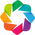

In [1]:
import numpy as np
import scipy.optimize
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from tqdm import tqdm

import bokeh.io
import bokeh.plotting
import holoviews as hv
import corner

%matplotlib inline
bokeh.io.output_notebook()
hv.extension('bokeh')

# Set some plotting options for holoviews.
%opts Scatter [bgcolor='whitesmoke', show_grid=True]
%opts Curve [bgcolor='whitesmoke', show_grid=True]

## The problem 

How well does the thermodynamic model hold up across varying temperature? Everything we've done has focused exclusively on growth in M9 + 0.5% glucose held at 37°C. Thus, all of the copy numbers, binding contants, etc. have been determined at this "reference" temperature, $T_{ref}$. However, as binding energies are multiplied by $\beta = 1 / k_BT$, the value of the binding energy shouldn't change, just the temperature scaling of $\beta$.  In this notebook, I will look at some very old data of myoglobin $O_2$ binding at several different temperatures. This was conducted by [Ross and Fanelli]() in 1958 and was performed all *in vitro*. 

##  A simple thermodynamic model of Myoglobin-$O_2$ binding

We can treat myoglobin as a simple two state system in which there is an empty state ($O_2$ unbound) and a bound state (coordinated with one $O_2$ molecule). As Myoglobin is a monomeric protein, we can ignore all allosteric and cooperative effects and treat it as a simple binding curve. From this simple siystem, we can write a simple expression for the probability of oxygen being bound as

$$
P_\text{bound} = {{p \over p_0}e^{-\Delta\varepsilon / k_BT} \over 1 + {p \over p_0}e^{-\Delta\varepsilon / k_BT}},
$$

Where $\Delta\varepsilon$ is the binding energy of $O_2$ to Myoglobin, $p$ is the partial pressure of oxygen, $p_0$ is a reference pressure (for this case, 1mmHg), and $k_BT$ is the thermal energy **of the system**. To be more explicit, the probability of the bound state (including temperature effects) can be written as

$$
P_\text{bound} \propto e^{-\Delta\varepsilon ({k_BT_{ref} \over k_BT_{system}})}
$$

where $T_{ref}$ is the "standard" reference temperature and $T_{system}$ is (obviously) the temperature of the system. For now, I'll ignore any entropic effects and just see how well we can fit the Ross & Fanelli data by calcuating the binding energy at a single temperature, then using the other temperature in the $\beta$ predict the others.  

## Fitting $\Delta\varepsilon$ 

Let's load and plot the raw data.

In [2]:
%%opts Scatter [width=600, height=400, legend_position='bottom', fontsize=12] (size=5)

# Load the data. 
data = pd.read_csv('../../data/other/ross_fanelli_1958.csv', comment='#')

# Group the data by temperature and plot on the same curve. 
scatter = hv.Scatter(kdims=['pO2', 'temp'], vdims=['frac'],
                    data=data).groupby(['temp'])
scatter.overlay(['temp'])

:NdOverlay   [temp]
   :Scatter   [pO2]   (frac)

It's a pretty arbitrary choice, but we can fit the value of $\Delta\varepsilon$ at a reference temperature $T_{ref}$ of 20°C. I'll choose this one simply because it seems to have the largest dynamic range and many data points.  The regression of this parameter should be pretty simple to implement from a Bayesian perspective. The posterior distribution we would like to compute is given as 

$$
P(\Delta\varepsilon \,\vert\,p_\text{bound}, pO_2 I) \propto P(p_\text{bound}\, \vert\, \Delta\varepsilon, pO_2)P(\Delta\varepsilon\,\vert\, I).
$$


The likelihood, $P(p_\text{bound}\,\vert\,\Delta\varepsilon)$ should be normally distributed,


$$
P(p_\text{bound}\,\vert\,\Delta\varepsilon, pO_2) = \mathcal{N}(p_\text{bound}^*, \sigma)
$$

where $p_\text{bound}^*$ is the mean probability at a given pressure and $\sigma$ is the variance. The introduction of sigma means we have now another prior to include. We can assign $\sigma$ a Jeffreys prior,

$$
P(\sigma) = {1 \over \sigma}
$$ 

and a uniform prior on $\Delta\varepsilon$,

$$
P(\Delta\varepsilon) = \begin{cases} {1 \over \Delta\varepsilon_{max} - \Delta\varepsilon_{min}} && \Delta\varepsilon_{min} \leq \Delta\varepsilon \leq \Delta\varepsilon_{max}\\
0 && \text{otherwise}.
\end{cases}
$$

To perform the estimate, we will use Markov Chain Monte Carlo methods in the PyMC3 package. We can define some useful functions below.

In [29]:
def jeffreys(val):
    """
    Computes the Jeffrey's prior for a given value. 
    """
    return -tt.log(val)

def simple_binding(pO2, epsilon, theta, p0=760):
    """
    Computes p_bound of a simple binding curve. 
   
    Parameters
    ----------
    pO2 : numpy 1d-array
        Range of oxygen pressures over which to compute
        the binding probability. This should be in units 
        of the reference partial pressure. 
    epsilon : float or PyMC3 RV
        Binding energy of oxygen to myoglobin.
    theta: float
        Ratio of T_ref / T_sys.
    
    Returns
    -------
    p_bound : 1d-array
        The probability of binding computed at each 
        pressure. 
    """
    numer = (pO2 / p0) * np.exp(-epsilon * theta)
    denom = 1 + numer
    return 1 / (1 + numer**-1)

def trace_to_df(trace, model):
    """
    Converts the trace from a pymc3 sampling trace to a
    Pandas DataFrame.
    """

    def compute_logp(chain):
        """
        Computes the log probability of the provided trace
        at a given chain.
        """
        names = trace.varnames
        var_dict = {}
        for n in names:
            var_dict[n] = trace.get_values(n, chains=chain)
        sample_df = pd.DataFrame(var_dict)

        logp = [model.logp(sample_df.iloc[step]
                           ) for step in range(len(sample_df))]
        return logp

    chains = trace.chains
    for c in tqdm(chains, desc='Processing chains'):
        logp = compute_logp(c)
        if c == 0:
            df = pm.trace_to_dataframe(trace, chains=c)
            df.insert(np.shape(df)[1], 'logp', logp)
        else:
            _df = pm.trace_to_dataframe(trace, chains=c)
            _df.insert(np.shape(_df)[1], 'logp', logp)
            df.append(_df, ignore_index=True)

    return df


def mcmc_sample(pO2, observed, theta=1, bounds=[-30, 0],
               mcmc_kwargs={'draws':1000, 'tune':10000,
                            'njobs':None}):
    """
    Performs MCMC on the simple binding posterior. 

    Parameters
    ----------
    pO2 : numpy 1d-array
        Array of partial pressure values in units of
        the reference concentration.  
    observed : 1d-array 
        Observed binding probability at a given 
        temperature and pressure.
    theta : float
        Ratio of T_ref / T_system
    bounds : list of floats or ints. 
        Lower and upper bounds for the prior on epsilon
    mcmc_kwargs : tuple
        kwargs for the mcmc sample.
        
    Returns
    ------- 
    df : pandas DataFrame
        DataFrame of PyMC3 trace inclduing the log
        posterior probability at each step.
        
    [trace, model] : PyMC3 trace object and model
        The MCMC trace and model object. 
    """
    # Define the model. 
    model = pm.Model()
    with model:
        # Define the priors
        epsilon = pm.Normal('epsilon', mu=-10, sd=10)
                            
        sigma = pm.HalfNormal('sigma')
        
        # Compute the expected value.
        p_bound_theo = simple_binding(pO2, epsilon, theta)
        
        # Define the likelihood. 
        like = pm.Normal('likelihood', mu=p_bound_theo, sd=sigma, observed=observed)
        
        # Find the MAP
        start = pm.find_MAP(model=model, fmin=scipy.optimize.fmin_powell)
        
        
        # Sample the posterior.
#         step = pm.Metropolis()
#         burn = pm.sample(draws=20000, start=start, step=step)
#         step = pm.Metropolis()
        trace = pm.sample(tune=100000, draws=50000, start=start, njobs=None)

        
        # Convert the trace to a dataframe. 
        df = trace_to_df(trace, model)
        
    return df, [trace, model]



def compute_statistics(df, ignore_vars='logp'):
    """
    Computes the mode and highest probability density (hpd)
    of the parameters in a given dataframe.
    """

    # Set up the multi indexing.
    var_names = np.array(df.keys())
    if ignore_vars is not None:
        var_names = var_names[var_names != ignore_vars]

    # Generate arrays for indexing and zip as tuples.
    names = [var for var in var_names] * 3
    stats = ['mode', 'hpd_min', 'hpd_max']
    stats = np.array([[s] * len(var_names) for s in stats]).flatten()
    tuples = list(zip(*[names, stats]))

    # Define the index.
    index = pd.MultiIndex.from_tuples(tuples, names=['var', 'stat'])

    # Determine the mode for each
    mode_ind = np.argmax(df['logp'])
    stat_vals = [df.iloc[mode_ind][var] for var in var_names]
    # Compute the min and max vals of the HPD.
    hpd_min, hpd_max = [], []
    for i, var in enumerate(var_names):
        _min, _max = hpd(df[var], 0.95)
        hpd_min.append(_min)
        hpd_max.append(_max)
    for _ in hpd_min:
        stat_vals.append(_)
    for _ in hpd_max:
        stat_vals.append(_)

    # Add them to the array for the multiindex
    flat_vals = np.array([stat_vals]).flatten()
    var_stats = pd.Series(flat_vals, index=index)

    return var_stats

def hpd(trace, mass_frac):
    """
    Returns highest probability density region given by
    a set of samples.
    Parameters
    ----------
    trace : array
        1D array of MCMC samples for a single variable
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For hreple, `massfrac` = 0.95 gives a
        95% HPD.

    Returns
    -------
    output : array, shape (2,)
        The bounds of the HPD

    Notes
    -----
    We thank Justin Bois (BBE, Caltech) for developing this function.
    http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html
    """
    # Get sorted list
    d = np.sort(np.copy(trace))

    # Number of total samples taken
    n = len(trace)

    # Get number of samples that should be included in HPD
    n_samples = np.floor(mass_frac * n).astype(int)

    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n - n_samples]

    # Pick out minimal interval
    min_int = np.argmin(int_width)

    # Return interval
    return np.array([d[min_int], d[min_int + n_samples]])         

With those functions defined, we can look at only the 20°C data and fit for $\Delta\varepsilon$

In [30]:
# Define the necessary parameters. 
data_20C = data[data['temp']==20]
T_REF = 20  # in units of C
T_sys = data_20C['temp'].values
theta = T_REF / T_sys
pO2 = data_20C['pO2'].values 
frac = data_20C['frac'].values

# Run the MCMC.
df, _ = mcmc_sample(pO2, frac, theta=1, bounds=[-30, 0])
trace, model = _

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...


Optimization terminated successfully.
         Current function value: -22.395085
         Iterations: 3
         Function evaluations: 72


Average ELBO = 19.494: 100%|██████████| 200000/200000 [00:13<00:00, 14952.47it/s]
Finished [100%]: Average ELBO = 19.478
INFO:pymc3:Finished [100%]: Average ELBO = 19.478
Processing chains: 100%|██████████| 6/6 [00:58<00:00,  9.73s/it]


We can see how well the sampler ran by looking at the trace. 

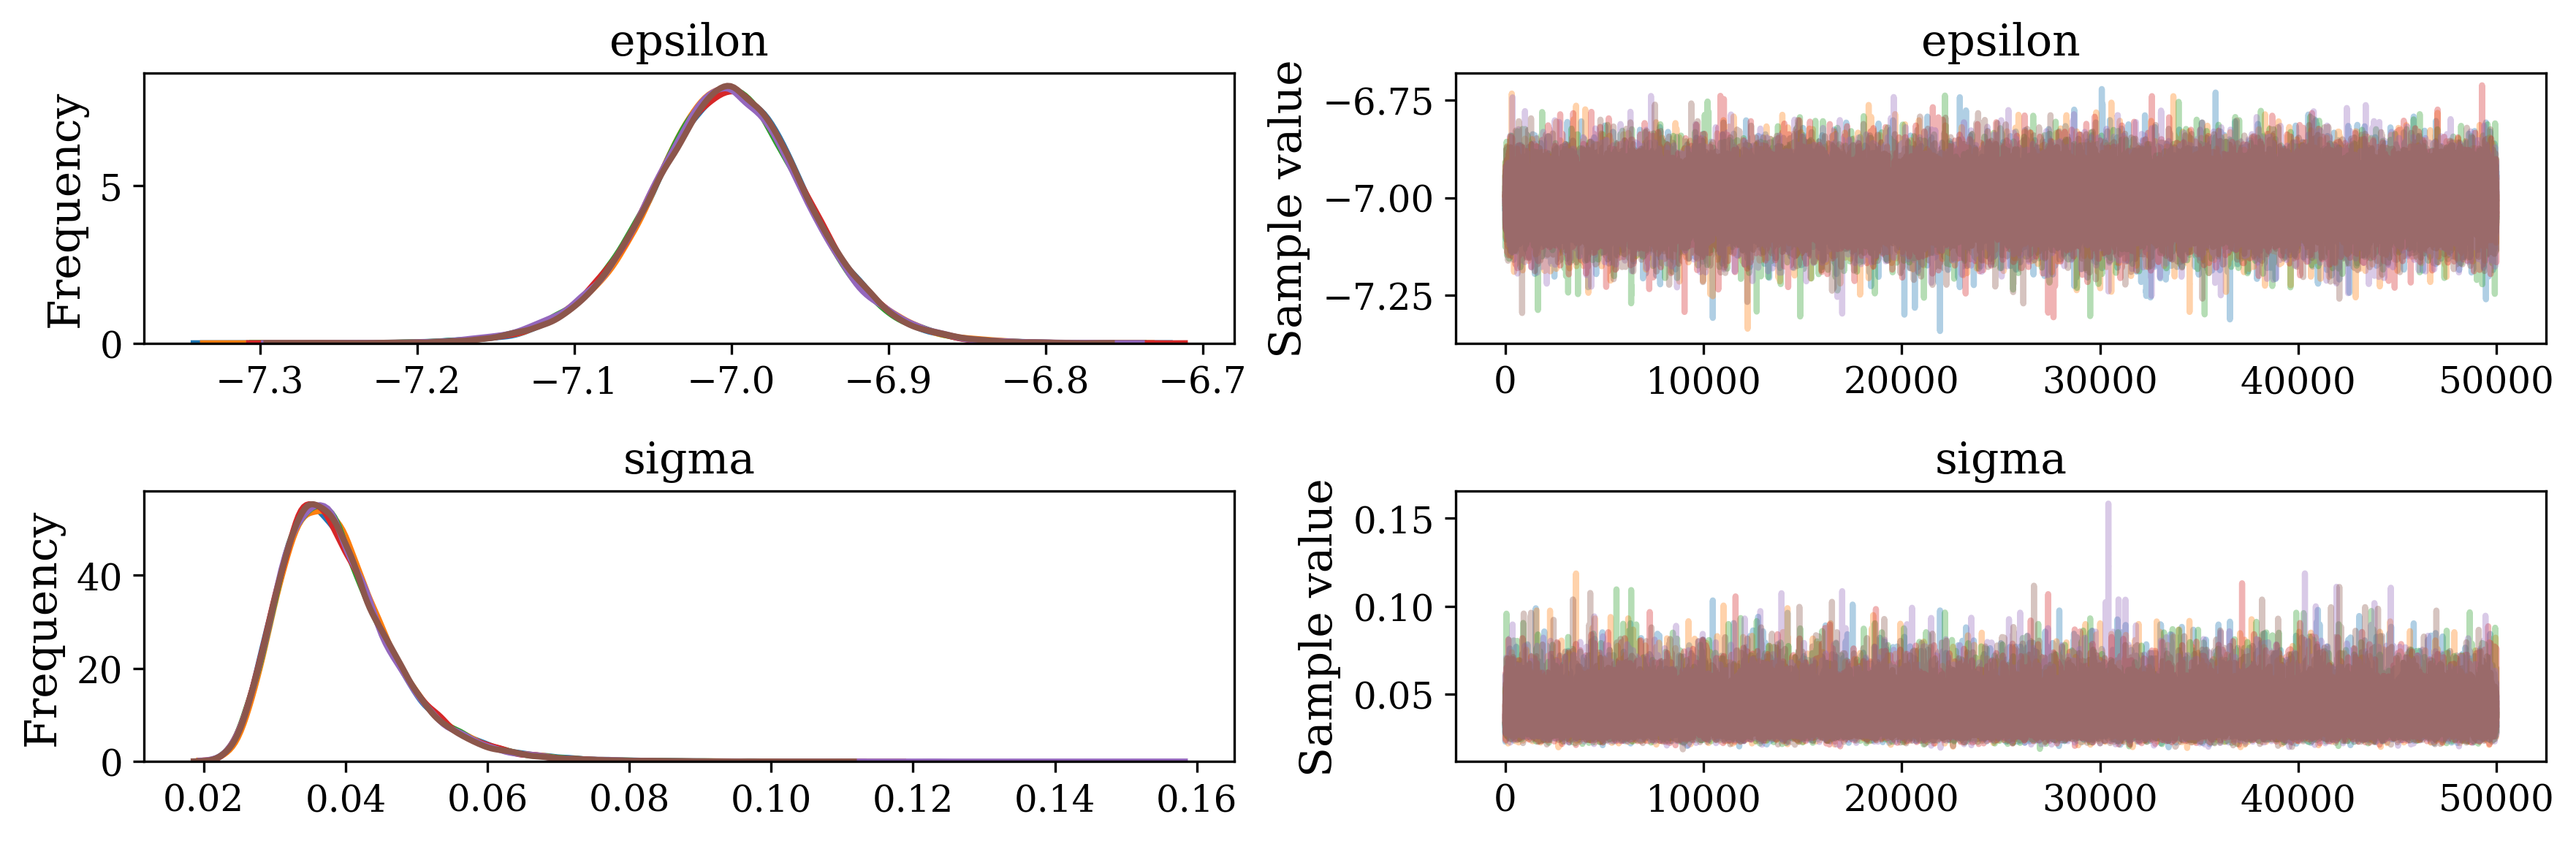

In [31]:
_ = pm.traceplot(trace)

Now let's compute and return the statistics. 

In [32]:
stats = compute_statistics(df)
stats['epsilon']

stat
mode      -7.002505
hpd_min   -7.105700
hpd_max   -6.898599
dtype: float64

With a mode and HPD for the binding energy, we can see how well the fit matches.

In [38]:
%%opts Scatter [width=600, height=400] (size=8 )
%%opts Curve (line_width=1, color='dodgerblue')
%%opts Area (line_color=None, fill_color='dodgerblue', alpha=0.3)

# Compute the fit
p_range = np.linspace(0, 5, 500)
fit = simple_binding(p_range, stats['epsilon'][0], theta=1)
fit_high = simple_binding(p_range, stats['epsilon'][1], theta=1)
fit_low = simple_binding(p_range, stats['epsilon'][2], theta=1)
scatter = hv.Scatter(kdims=['pO2'], vdims=['frac'], data=data_20C)
curve = hv.Curve((p_range, fit))
area = hv.Area((p_range,fit_low, fit_high), vdims=['fit_low', 'fit_high'])
(area * curve * scatter)

:Overlay
   .Area.I    :Area   [x]   (fit_low,fit_high)
   .Curve.I   :Curve   [x]   (y)
   .Scatter.I :Scatter   [pO2]   (frac)

That looks pretty great! Now let's see how this works with the other fits.

In [34]:
p = bokeh.plotting.figure(plot_width=600, plot_height=400, background_fill_color='whitesmoke')
grouped = data.groupby('temp')
out = []
colors = ['dodgerblue', 'tomato', 'slategray', 'coral', 'forestgreen']
i = 0
for g, d in grouped: 
    theta =  (T_REF + 273.15)/ (d['temp'].unique() + 273.15)
    fit = simple_binding(p_range, stats['epsilon'][0], theta)
    p.circle(d['pO2'], d['frac'], color=colors[i])
    p.line(p_range, fit, color=colors[i])    
    i+= 1
    
bokeh.io.show(p)